In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_data_label(filename):
    '''
    Load data with label specified
    '''
    data = []
    with open(filename) as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip().split()
            data_line = [float(i) for i in line]
            data.append(data_line)
    return data

def dataPartitionPreprocessing_feature(feature, eps, minpts, K1):
    # feature1
    size = feature.shape[0]
    feature_rdd = sc.parallelize(feature, 4)
    pmin = min(feature)
    pmax = max(feature)
    s = (pmax-pmin)/(2*eps)
    intervals = []
    start = pmin
    end = start+2*eps
    while start < pmax and end < pmax:
        count = feature_rdd.filter(lambda x : x>=start and x < end).count()
        if count >= max(minpts, size/K1) :
            intervals.append((start, end))
            start = end
            end = start+2*eps
        else:
            end = end + 2*eps
    intervals.append((start, end))
    return intervals
 

In [10]:
def Local_DBSCAN(df, distance=3, neighbours_cnt=3):
    # df1: give points id
    df1 = df.copy()
    df1 = df1.rename(columns={'feature1': 'feature1_1', 'feature2': 'feature2_1'})
    df2 = df1.copy()  # just points
    df1["id_1"] = range(1, len(df) + 1)
    # df_distance, svae the distance between two points
    df_distance = pd.DataFrame(columns=["id_1", "id_2", "distance_ab"])
    b = df2.loc[:, ["feature1_1", "feature2_1"]].values
    for i in range(len(df2)):
        a = df2.loc[i, ["feature1_1", "feature2_1"]].values
        dfpair = df1[['id_1']].copy()
        dfpair["id_2"] = i + 1
        dfpair["distance_ab"] = np.sqrt(np.sum((a - b) ** 2, axis=1))  # compute the distance
        df_distance = pd.concat([df_distance, dfpair])
    # dfnears: save every point with their neighbours set
    dfnears = df_distance[df_distance['distance_ab'] < distance]
    dfnears = dfnears.groupby("id_1").agg({"id_2": [len, set]})
    dfnears.columns = ["neighbours_cnt", "neighbours"]
    dfnears = dfnears[dfnears['neighbours_cnt'] >= neighbours_cnt]
    dfnears = dfnears.reset_index()
    # dfcores:save the neighbors which are also core points
    core_ids = set(dfnears["id_1"].values)
    dfcores = dfnears.copy()
    dfcores["neighbours"] = [x & core_ids for x in dfcores["neighbours"]]
    set_list = list(dfcores["neighbours"])
    # merge the neighboures set
    result = []
    while len(set_list) > 0:
        cur_set = set_list.pop(0)
        intersect_idxs = []
        for i in list(range(len(set_list) - 1, -1, -1)):
            if cur_set & set_list[i]:
                intersect_idxs.append(i)
        while intersect_idxs:
            for idx in intersect_idxs:
                cur_set = cur_set | set_list[idx]
            for idx in intersect_idxs:
                set_list.pop(idx)
            intersect_idxs = []
            for i in list(range(len(set_list) - 1, -1, -1)):
                if cur_set & set_list[i]:
                    intersect_idxs.append(i)
        result = result + [cur_set]
    # core_clusters, give every cluster id
    core_clusters = {i: s for i, s in enumerate(result)}
    # cluster_map, give every point id
    core_map = {}
    for k, v in core_clusters.items():
        core_map.update({vi: k for vi in v})
    cluster_map = {}
    for i in range(len(dfnears)):
        id_a = dfnears["id_1"][i]
        neighbours = dfnears["neighbours"][i]
        cluster_map.update({idx: core_map[id_a] for idx in neighbours})
    # cluster_list give every point cluster_id
    cluster_list = []
    for id_1 in df1["id_1"]:
        cluster_list.append(cluster_map.get(id_1, -1))
    # update df1, add the cluster_id
    df1["cluster_id"] = cluster_list

    # draw picture
    df1.plot.scatter('feature1_1', 'feature2_1', s=100,
                     c=list(df1['cluster_id']), cmap='rainbow', colorbar=False,
                     alpha=0.6, title='Hands DBSCAN Cluster Result ')
    return df1


In [11]:
def plotResult(data,x='feature1',y='feature2'):
    clusters_num = set(data['cluster_id'])
    colors = ['#ddff95','#f1ccb8','#cf8878','#f1f1b8','#b8f1cc','#f1707d','#E0EEEE','#66CDAA','#66CDAA']
    count=0
    for c in clusters_num:
        data.loc[data.cluster_id==c, 'colors'] = colors[count]
        count+=1
    scatter = plt.scatter(list(data[x]), list(data[y]), c=list(data['colors']))
#     plt.legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
    plt.show()
    return data


In [12]:
def clustering(x):
    l = []
    global eps
    global minpts
    l = list(x)
    dfdata = l[0]
    output = Local_DBSCAN(dfdata,eps.value, minpts.value)
    
    yield [output]

def merging(res,numpartitions):
    res = res.collect()
    last_max = -1
    list_df = []
    for i in range(numpartitions):
        cur = res[i][0]
        
        cur['cluster_id']+= last_max+1
        last_max = max(cur['cluster_id'])
        list_df.append(cur)
    res = pd.concat(list_df)
    res = res.rename(columns ={'id_1': 'id', 'feature1_1': 'feature1', 'feature2_1':'feature2'})
    res['coord'] = res.apply(lambda x: (x.feature1,x.feature2), axis=1)
    output = res.copy()
    coords = set(output['coord'])
    for coord in coords:
        clusters = set(output.loc[output.coord==coord, 'cluster_id'])
        min_cluster = min(clusters)
        output.loc[output.cluster_id.isin(clusters),'cluster_id'] = min_cluster
    output = output.drop(columns=['id'])
    output = output.drop_duplicates()
    return output


In [13]:
   
origin_data = np.array(load_data_label('spiral.txt'))
train_data = origin_data[:,:2]
partition_eps = 2
partition_minpts = 10
#processing partition on feature1 dimension
feature1_interval = dataPartitionPreprocessing_feature(train_data[:,0], partition_eps, partition_minpts, 4)

#processing partition on feature2 dimension
data_rdd = sc.parallelize(train_data, 4).cache()
partition = 0
rdd_t = sc.parallelize([]).cache()
for each_interval in feature1_interval:
    cur_data = data_rdd.filter(lambda x: x[0]>=each_interval[0] and x[0] <each_interval[1]).collect()
    cur_df = pd.DataFrame(cur_data)
    interval2 = dataPartitionPreprocessing_feature(cur_df[1], partition_eps,partition_minpts,5)
    for each_interval2 in interval2:
        region = data_rdd.filter(lambda x : x[0]>=each_interval[0]-partition_eps and x[0]<= each_interval[1]+partition_eps and x[1]>=each_interval2[0]-partition_eps and x[1] <= each_interval2[1]+partition_eps).map(lambda x: (partition,x))
        rdd_t=rdd_t.union(region)
        partition+=1
    
partitioned = rdd_t.partitionBy(partition)

In [14]:



def reduceFunc(x,y):
    if not isinstance(x, pd.DataFrame):
        x = x.reshape([1,2])
        df = pd.DataFrame(x, columns=['feature1', 'feature2'])
    else: 
        df = x
    if not isinstance(y, pd.DataFrame):
        y = y.reshape([1,2])
        dfy = pd.DataFrame(y, columns=['feature1', 'feature2'])
    else:
        dfy = y
    df = df.append(dfy)
    return df
def drop_index_column(x):
    x = x[1].reset_index()
    x = x.drop('index',1)
    return x
partitioned = partitioned.reduceByKey(reduceFunc).map(drop_index_column)
eps = partition_eps
minpts = 2
eps = sc.broadcast(eps)
minpts = sc.broadcast(minpts)
res = partitioned.mapPartitions(clustering)
output = merging(res, res.count())
        

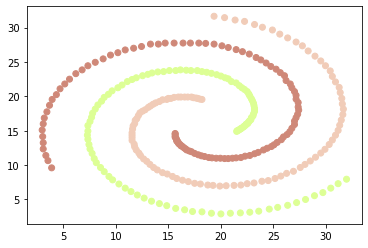

In [15]:
t =plotResult(output)

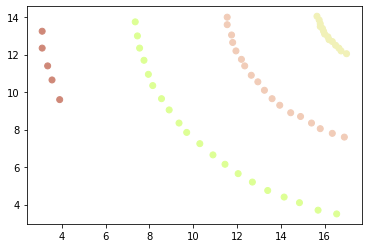

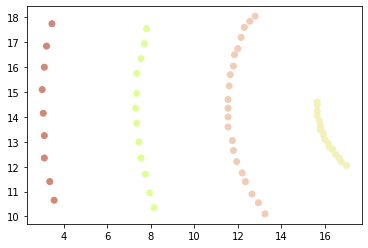

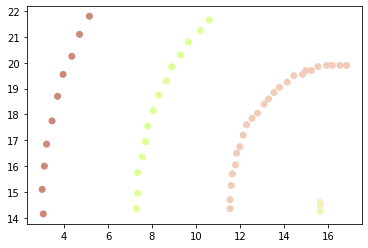

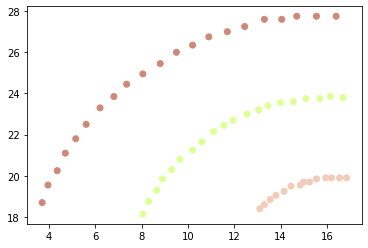

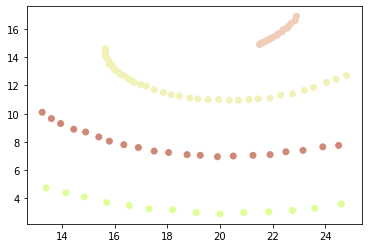

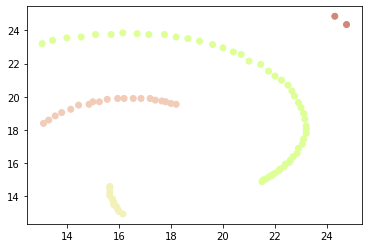

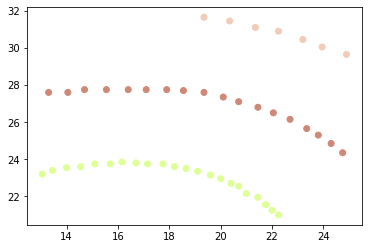

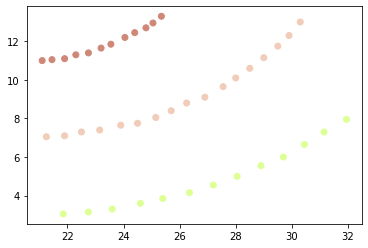

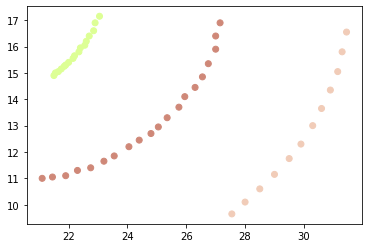

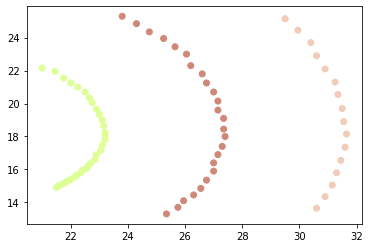

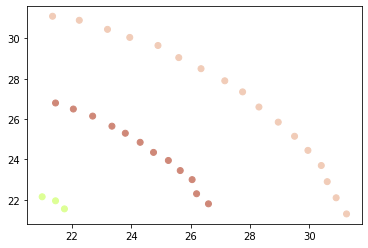

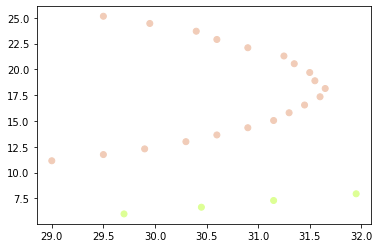

In [16]:
res_per_partition = res.collect()
for i in res_per_partition:
    i = i[0].rename(columns ={'id_1': 'id', 'feature1_1': 'feature1', 'feature2_1':'feature2'})
    plotResult(i)

In [17]:
len(output)

312